In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import pickle
from scipy.misc import derivative
import matplotlib.colors as mcolors

sns.set()

## Load data

In [36]:
with open('../data/presidentielle.pkl', 'rb') as f:
    data = pickle.load(f)

df1 = data['df1']
df2 = data['df2']

prop1 = data['prop1']
prop2 = data['prop2']

colnames = data['colnames']

model = tf.keras.models.load_model('../models/prop1_to_prop2')

del data

## Looking at predictions of model

We look at observed values against predicted values and overall see a good correlation between observed and predicted proportions.

In [ ]:
# We retrieve predictions
prop2_hat = pd.DataFrame(model.predict(prop1, verbose=0))
prop2_hat.columns = prop2.columns
prop2_all = pd.merge(prop2, prop2_hat,
                       left_index=True, right_index=True,
                       suffixes=['_Observed', '_Predicted'])
prop2_all = pd.merge(df1[colnames['id']], prop2_all,
                       left_index=True, right_index=True)

# We compute the pointwise error per voting station
def error(y_true, y_pred):
    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.cast(y_true, y_pred.dtype)
    y_true = tf.keras.backend.clip(y_true, tf.keras.backend.epsilon(), 1)
    y_pred = tf.keras.backend.clip(y_pred, tf.keras.backend.epsilon(), 1)
    return tf.math.abs(tf.math.log(y_true / y_pred))

for choice in colnames['choices2']:
    prop2_all[f'{choice}_Residual'] = error(
        prop2_all[f'{choice}_Observed'], 
        prop2_all[f'{choice}_Predicted'])

In [ ]:
for choice in colnames['choices2']:
    sns.lmplot(data=prop2_all,
               x=f'{choice}_Observed',
               y=f'{choice}_Predicted',
               line_kws={'color': 'red'},
               scatter_kws={'s': 1, 'color': '#ffb6c1', 'alpha': .5})
    plt.axline(xy1=(0, 0), slope=1, color='k')
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.title(choice)
    plt.xlabel('Observed')
    plt.ylabel('Predicted')

## Relation between the first and second round

We create hypothetical results using our trained model. For any voting station of the first round, we artificially deflate or inflate the results of a specific candidate, and use this new proportion to predict the second results using our model. This allows us to infer how the ballots of one first-round candidate are transferred to a second-round candidate.

We first define functions that allow us to study this relationship.

In [122]:
@tf.function
def model_predict(x):
    return model(x, training=False)

def predict_result(k, choice, row_prop1, model, prop2_columns):

    assert isinstance(choice, str), 'choice must be str'
    assert isinstance(row_prop1, pd.Series), 'prop1 must be pd.Series'

    choice_idx = row_prop1.index.get_loc(choice)

    k = np.array(k).reshape(-1).astype(np.float64)

    new_prop1 = row_prop1.copy().to_numpy().reshape(1, -1)
    new_prop1 = np.repeat(new_prop1, k.shape[0], axis=0)
    new_prop1[:, choice_idx] = k
    new_prop1 /= new_prop1.sum(axis=1, keepdims=True)
    new_prop1 = pd.DataFrame(new_prop1, columns=row_prop1.index)

    new_prop2_hat = model_predict(new_prop1)
    # new_prop2_hat = model.predict(new_prop1, verbose=0)
    new_prop2_hat = pd.DataFrame(new_prop2_hat, columns=prop2_columns)

    return new_prop1, new_prop2_hat

In [123]:
def predict_result_multiple_choices(k, row_prop1, model, prop2_columns):

    aux = []
    for choice in row_prop1.index:
        new_prop1, new_prop2_hat = predict_result(k, choice, row_prop1, model, prop2_columns)

        new_prop2_hat['Candidate'] = choice
        new_prop2_hat['Proportion'] = new_prop1[choice]
        aux.append(new_prop2_hat)

    return pd.concat(aux, axis=0)


In [125]:
def plot_results(new_prop2_hat,
                 station_index,
                 df1,
                 prop1,
                 prop2,
                 palette=['grey', 'darkred', 'darkblue']):

    data = new_prop2_hat.melt(id_vars=['Candidate',
                                       'Proportion'])
    data['variable'] = data['variable'].str.replace('_', ' ')
    data['Candidate'] = (data['Candidate'].
                                   str.
                                   replace('_', ' '))

    commune = df1.iloc[station_index]['NomCommune']
    department = df1.iloc[station_index]['NomDepartement']
    station = df1.iloc[station_index]['CodeBureauVote']

    g = sns.FacetGrid(data=data,
                      col='Candidate', col_wrap=3)
    g.map_dataframe(sns.lineplot,
                    x='Proportion', y='value',
                    hue='variable', palette=palette)
    g.set_xlabels(f'1st Round')
    g.set_ylabels(f'2nd Round')
    g.set_titles(col_template='{col_name}')
    g.fig.subplots_adjust(top=0.94)
    g.fig.suptitle(f'{commune}, {department}, {station}')
    g.axes[0].legend()
    for i, ax in enumerate(g.axes):
        ax.hlines(prop2.iloc[station_index], xmin=0, xmax=1,
                  color=palette, linestyles='dashed', linewidths=.5)
        ax.vlines(prop1.iloc[station_index, i], ymin=0, ymax=1,
                  color='k', linestyles='dashed', linewidths=.5)


We now plot results for randomly chosen voting stations. 

We see two consistent trends:
- voters of Le Pen, Zémmour, and Dupont-Aignan tend to give their ballots to Le Pen;
- voters of Macron, Jadot, and Hidalgo tend to give their ballots to Macron;
- it's not possible to know who voters of Lassalle vote for in the second round.

There are more complex trends for Mélenchon, Roussel, and Poutou voters who, depending on the station, either transfer their ballot to Macron or decide not to choose any candidate. 

A curious result that may show the limits of the analysis concerns voters of Arthaud. It appears that these voters transfer their ballot to Le Pen, which is unexpected given that these two candidates are opposites on the political spectrum.

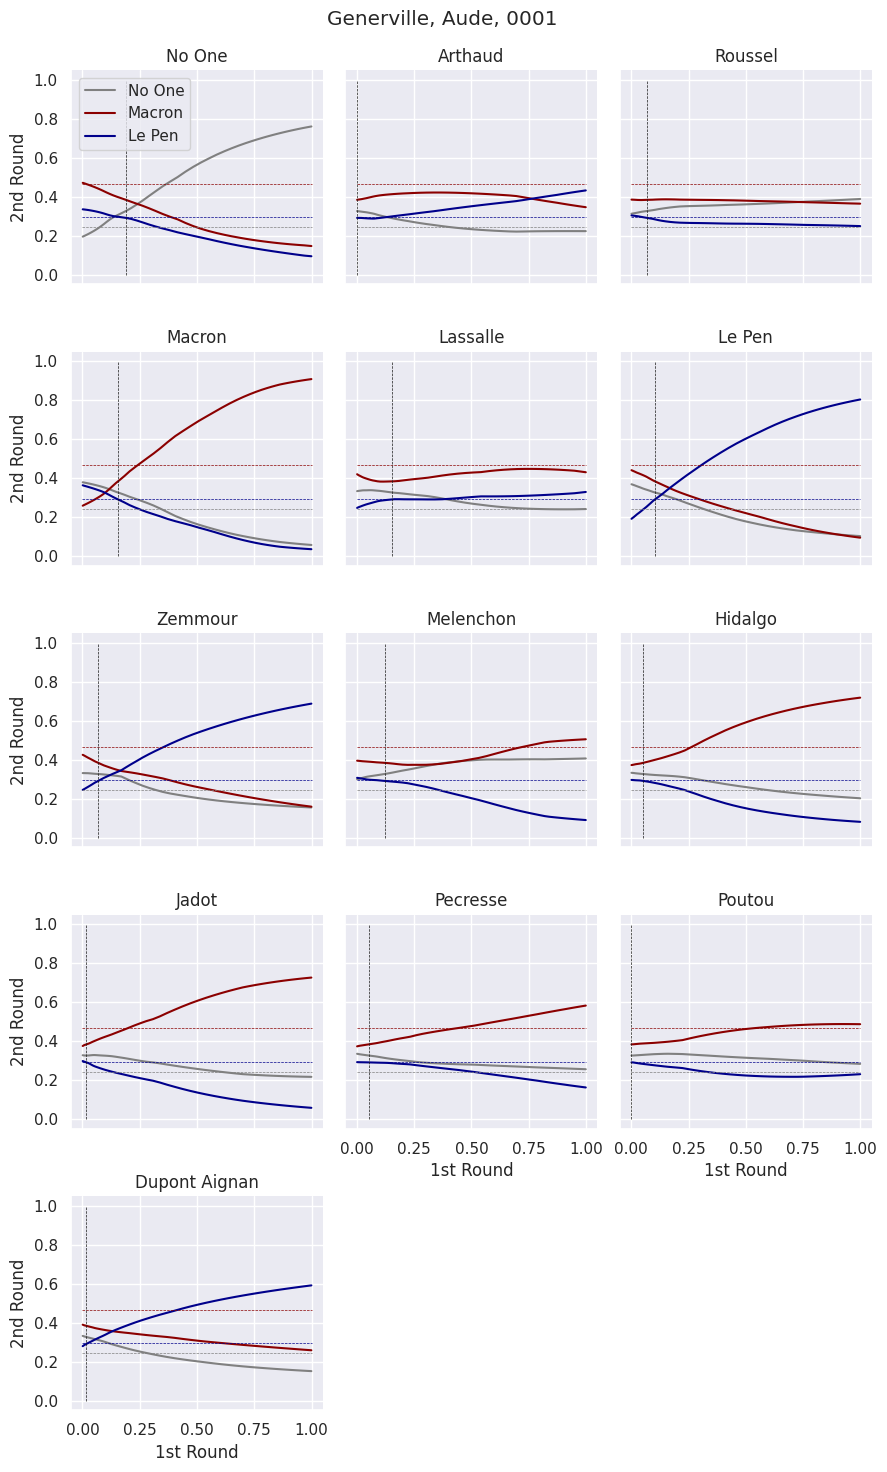

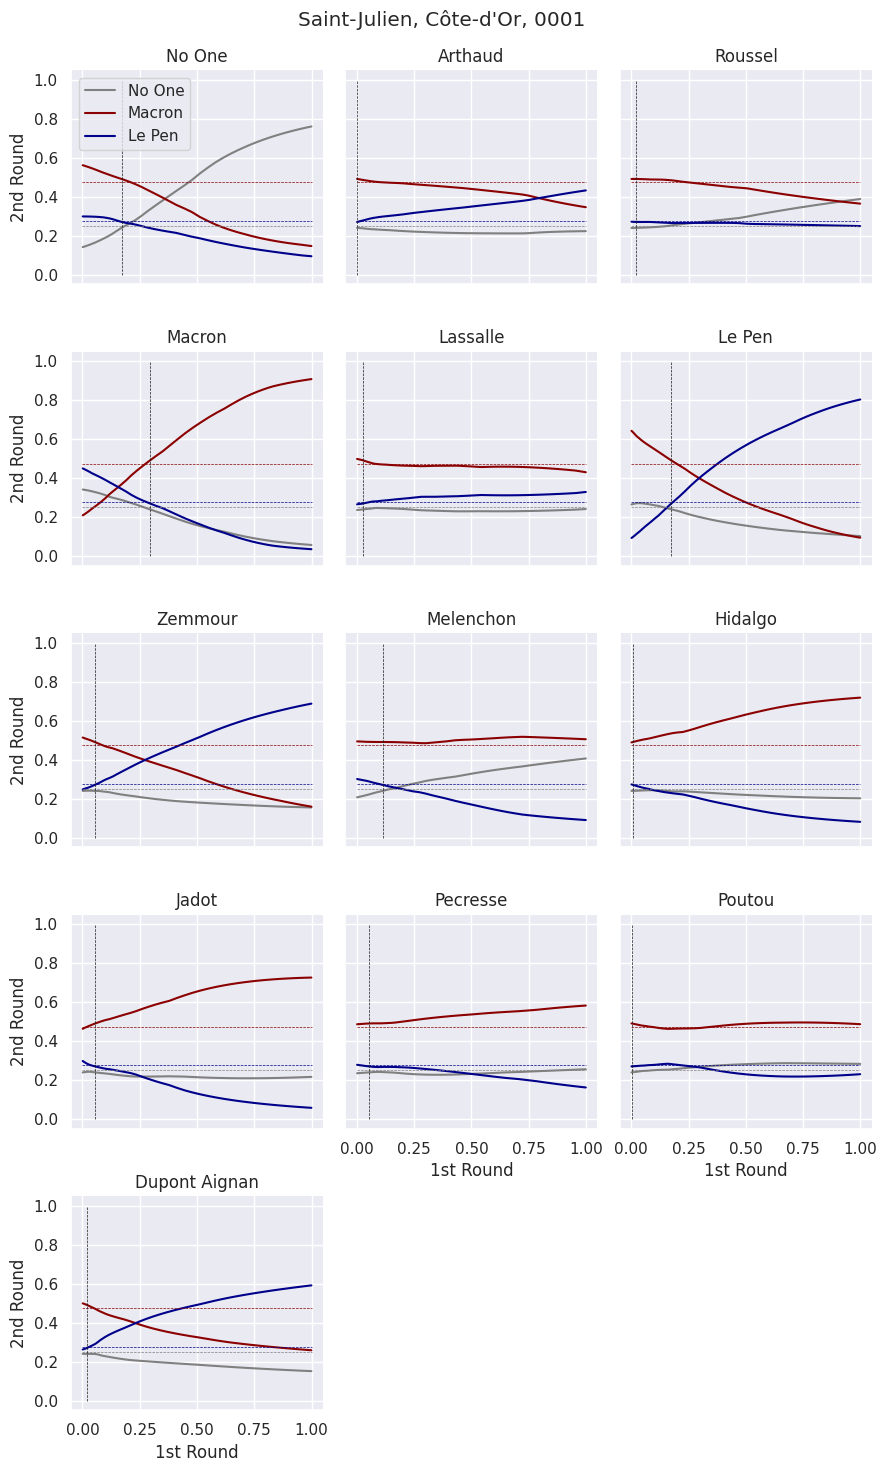

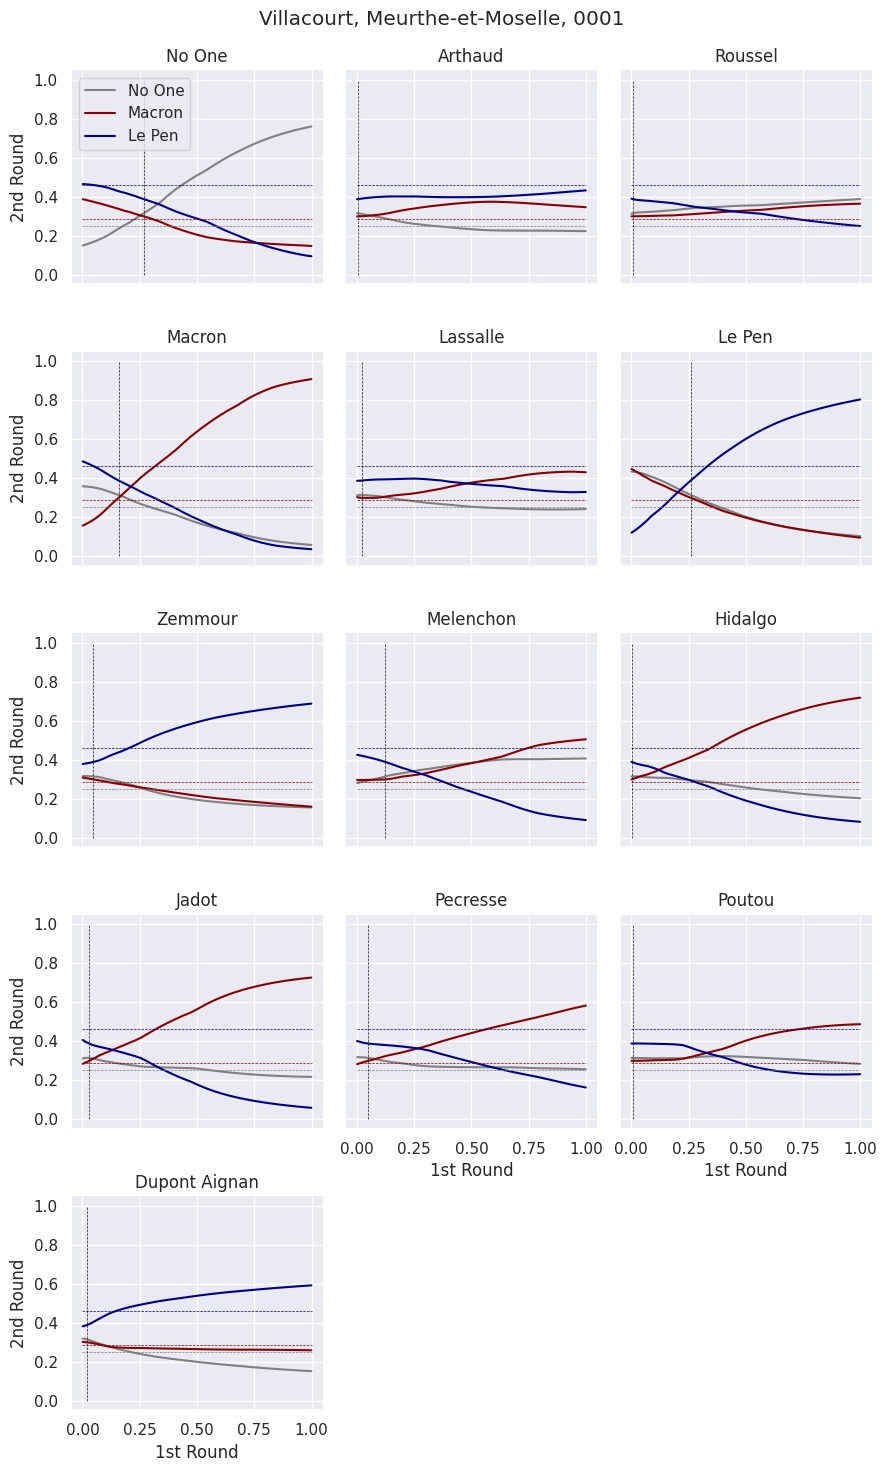

In [126]:
np.random.seed(63)
station_indices = np.random.randint(size=3, low=0, high=prop2.shape[0])
k = np.logspace(-3, 3, num=101)

for station_index in station_indices:
    new_prop2_hat = predict_result_multiple_choices(
        k=k,
        row_prop1=prop1.iloc[station_index],
        model=model,
        prop2_columns=prop2.columns)

    plot_results(
        new_prop2_hat=new_prop2_hat,
        station_index=station_index,
        df1=df1,
        prop1=prop1,
        prop2=prop2)


## Derivatives of Mélenchon

In [127]:
def f(x, i):
    x, y = predict_result(k=x,
                          choice="Melenchon",
                          row_prop1=prop1.iloc[i],
                          model=model,
                          prop2_columns=prop2.columns)
    return y["Macron"].values

station_indices = np.random.randint(size=10000, low=0, high=prop2.shape[0])

derivatives = np.array([derivative(
    f,
    x0=prop1["Melenchon"].iloc[i],
    dx=.01,
    args=[i])[0] for i in station_indices])


In [129]:
from sklearn.decomposition import PCA
pca1 = PCA(n_components=2)
prop1_subset = prop1.iloc[station_indices,:].reset_index(drop=True)
pca1.fit(prop1_subset.apply(lambda x: (x - x.mean()) / x.std(), axis=0))
pca_df1 = pca1.transform(prop1_subset)
pca_df1 = pd.DataFrame(pca_df1)
pca_df1.columns = ["PC" + str(x+1) for x in range(pca_df1.shape[1])]
pca_df1 = pd.concat([prop1_subset, pca_df1], axis=1)
pca_df1["Derivative"] = derivatives

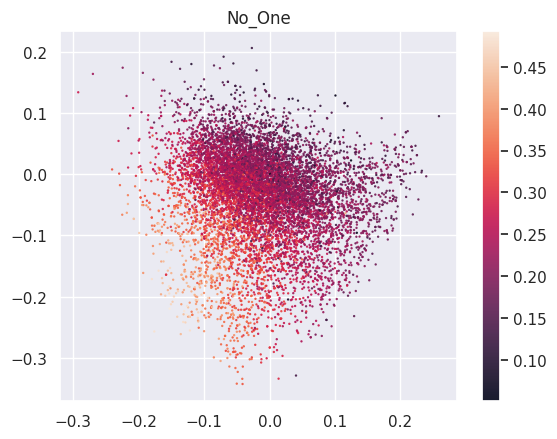

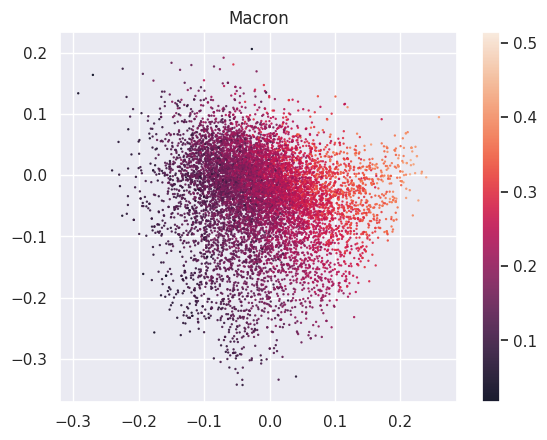

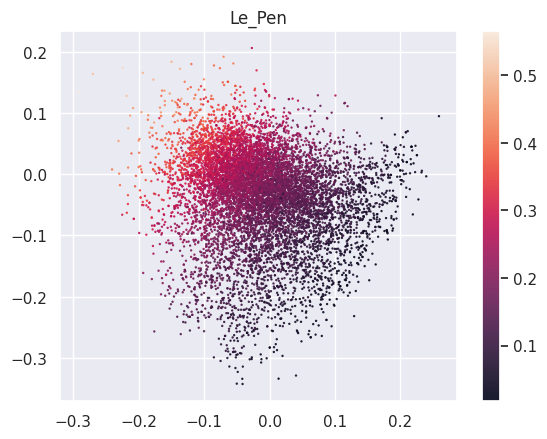

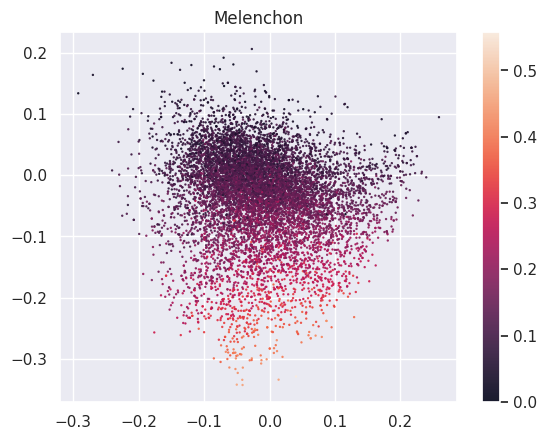

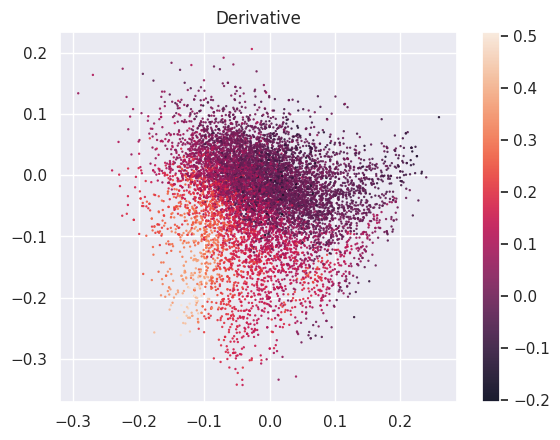

In [130]:
normalize = mcolors.TwoSlopeNorm(
    vcenter=0.0,
    vmin=pca_df1["Derivative"].min(),
    vmax=pca_df1["Derivative"].max())

for choice in list(prop2.columns) + ["Melenchon", "Derivative"]:
    plt.scatter(pca_df1["PC1"], pca_df1["PC2"],
                    c=pca_df1[choice], 
                    alpha=.9, 
                    s=.5)
    plt.title(choice)
    plt.colorbar()
    plt.show()


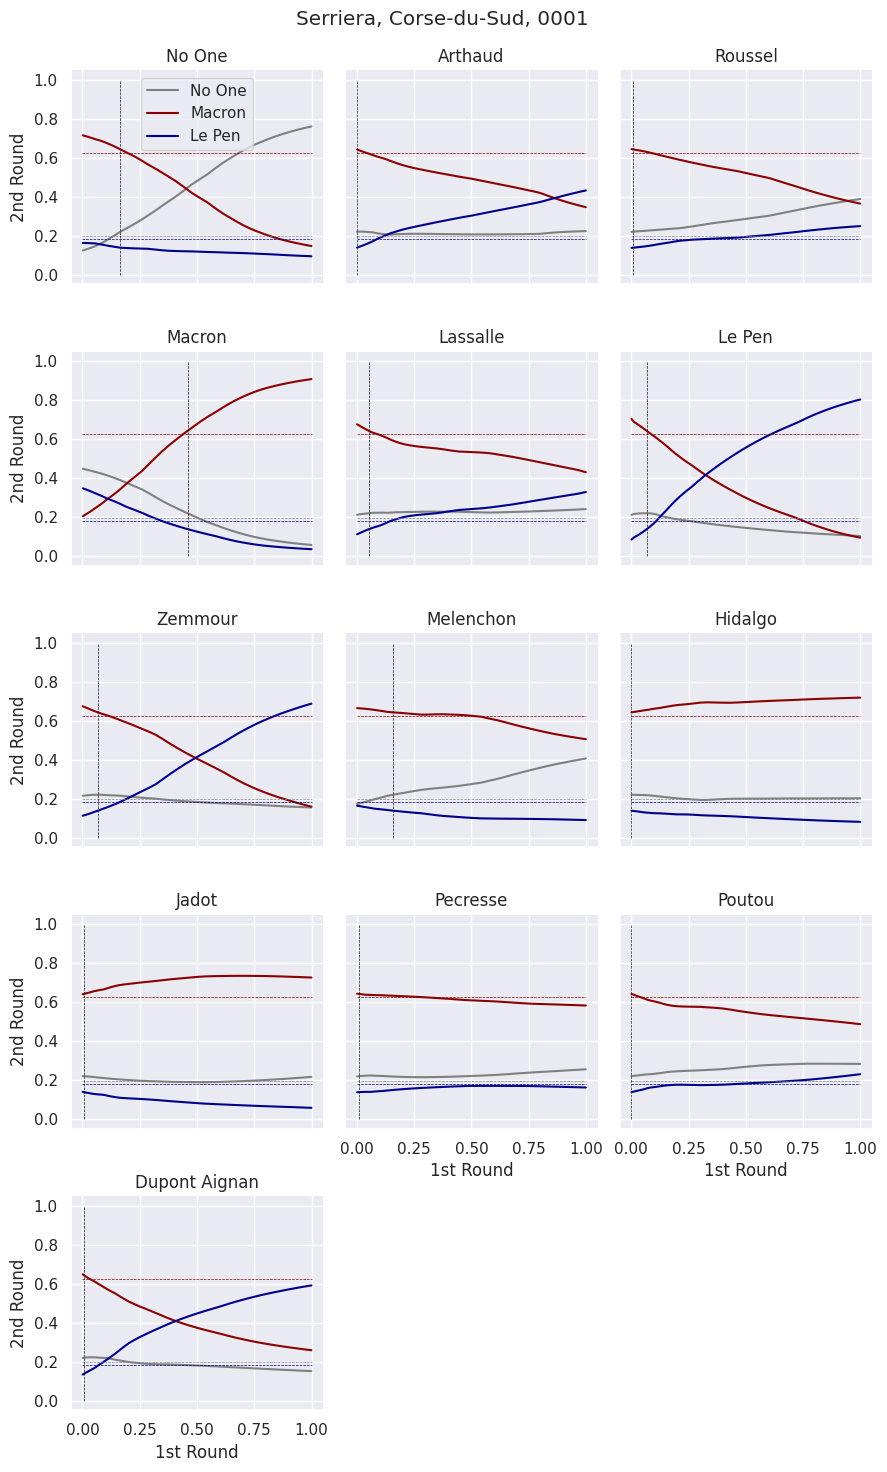

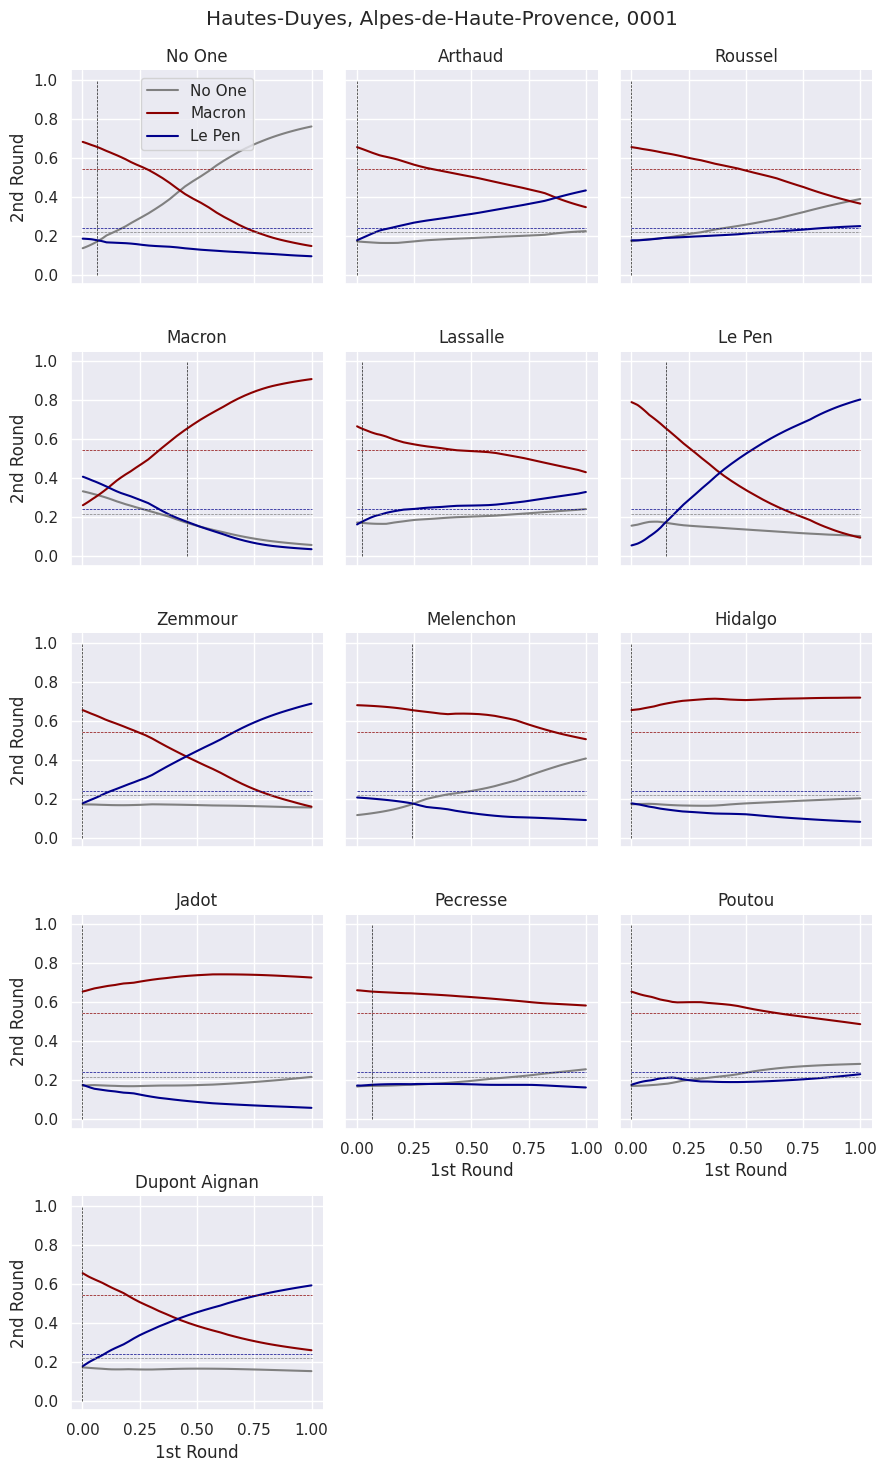

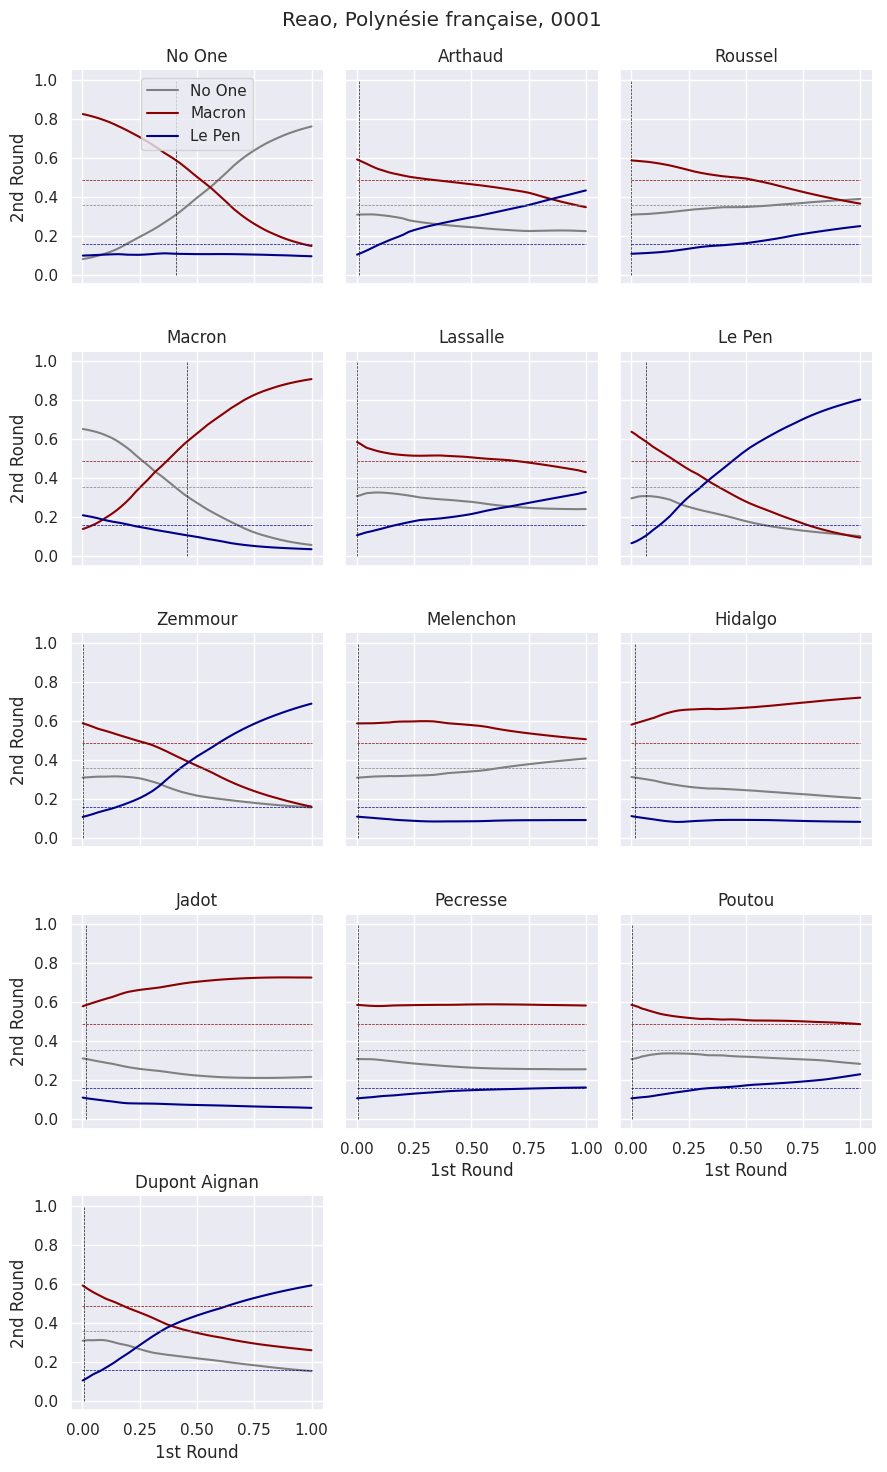

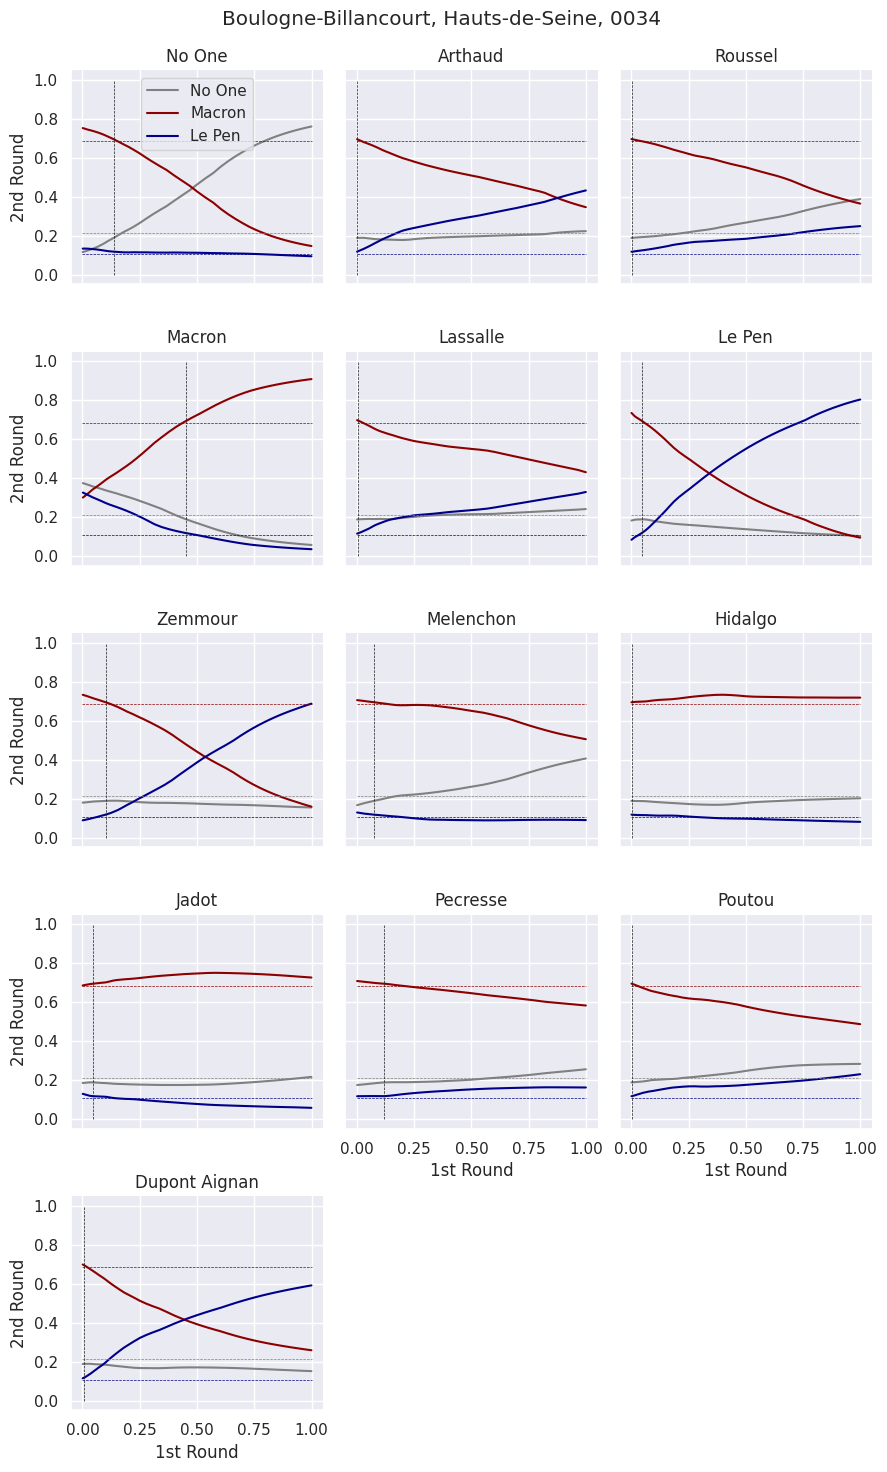

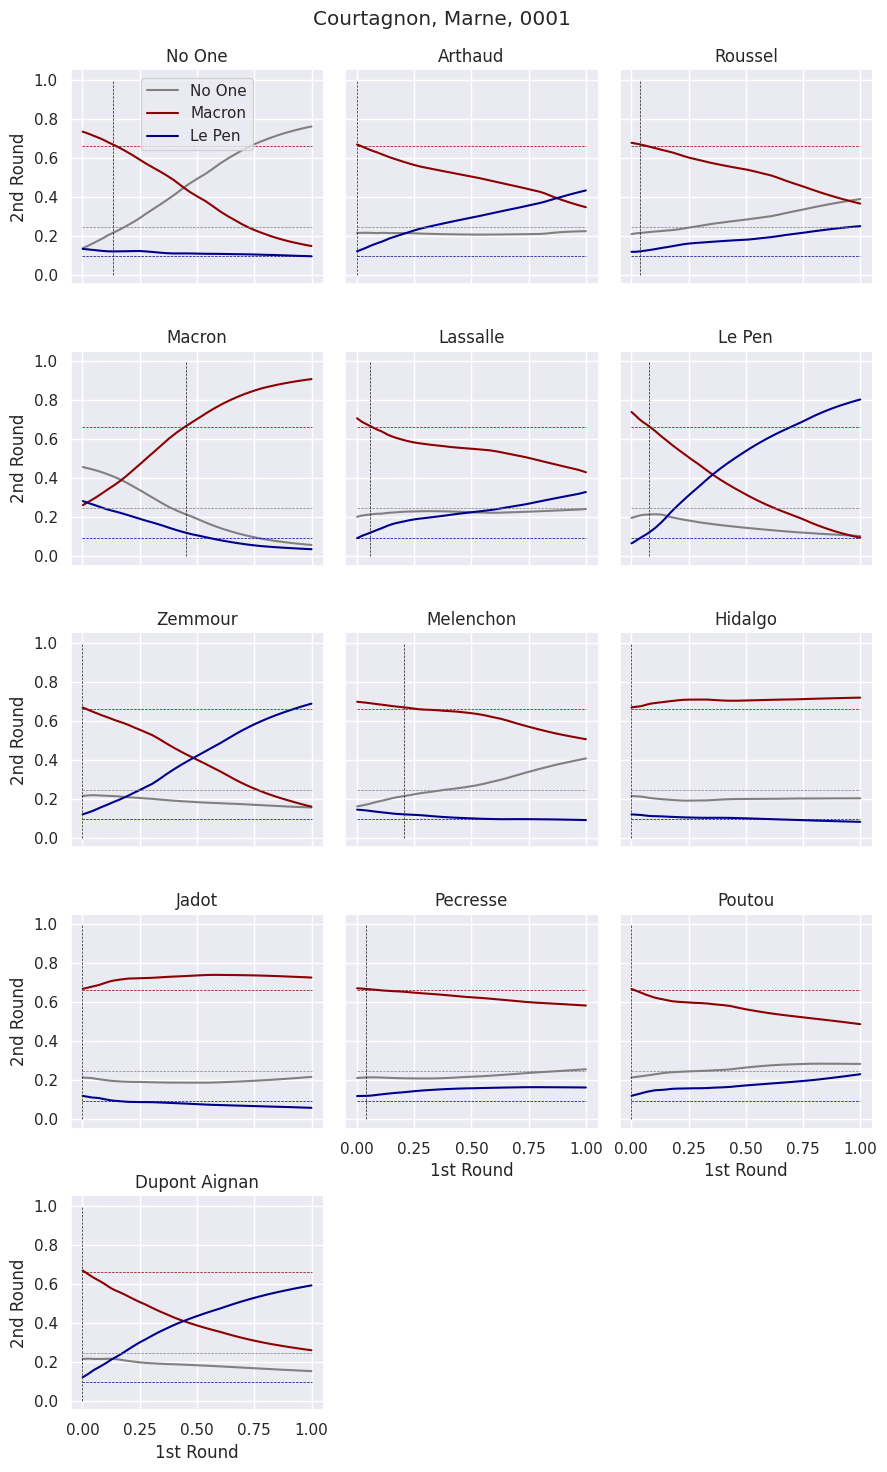

In [140]:
station_indices = prop1.Macron.sort_values(ascending=False).index[10:15]
k = np.logspace(-3, 3, num=101)

for station_index in station_indices:
    new_prop2_hat = predict_result_multiple_choices(
        k=k,
        row_prop1=prop1.iloc[station_index],
        model=model,
        prop2_columns=prop2.columns)

    plot_results(
        new_prop2_hat=new_prop2_hat,
        station_index=station_index,
        df1=df1,
        prop1=prop1,
        prop2=prop2)


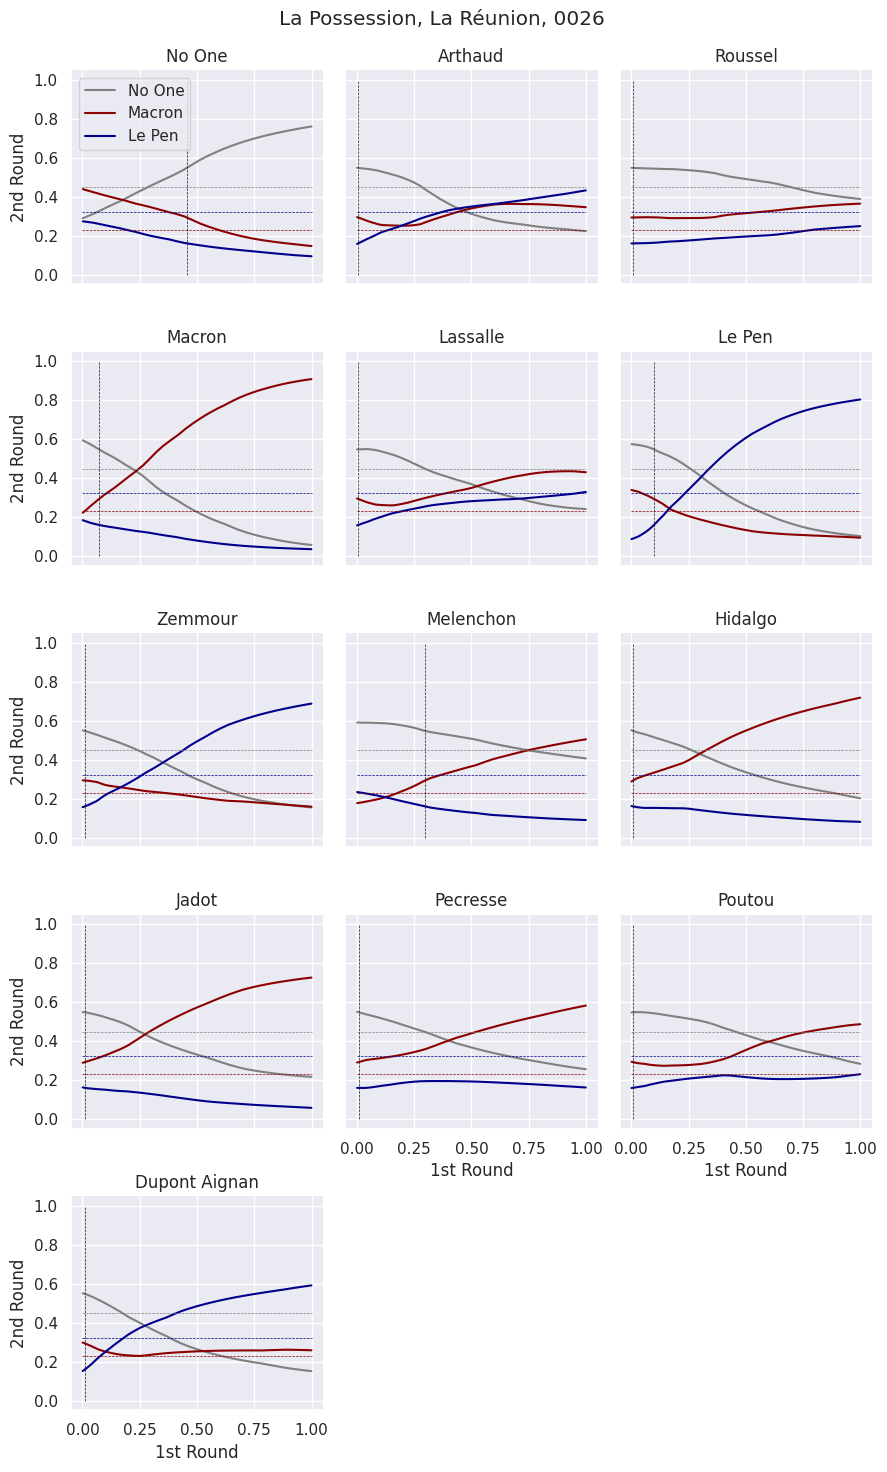

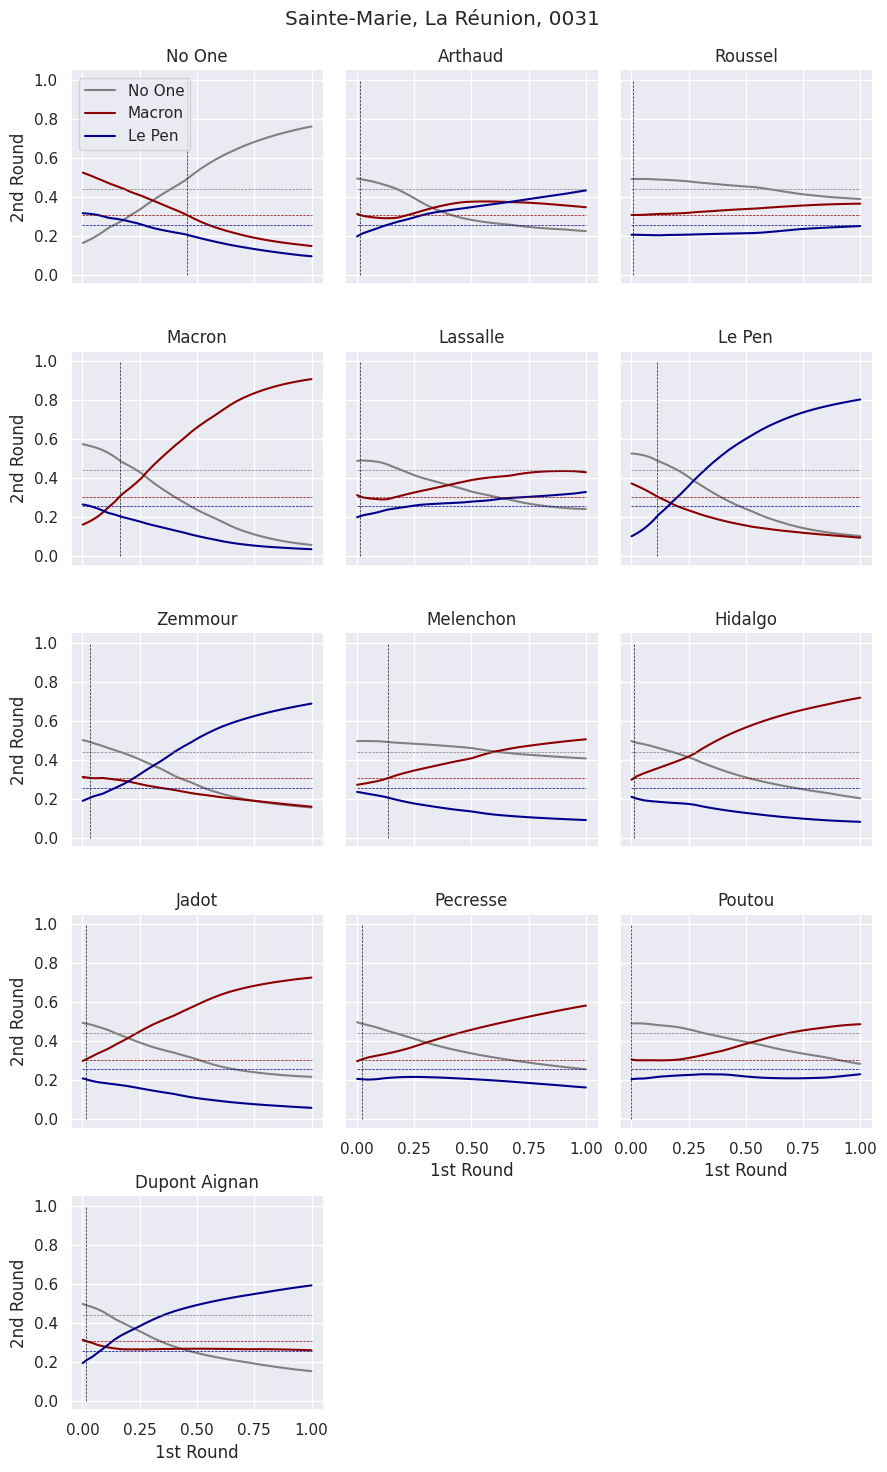

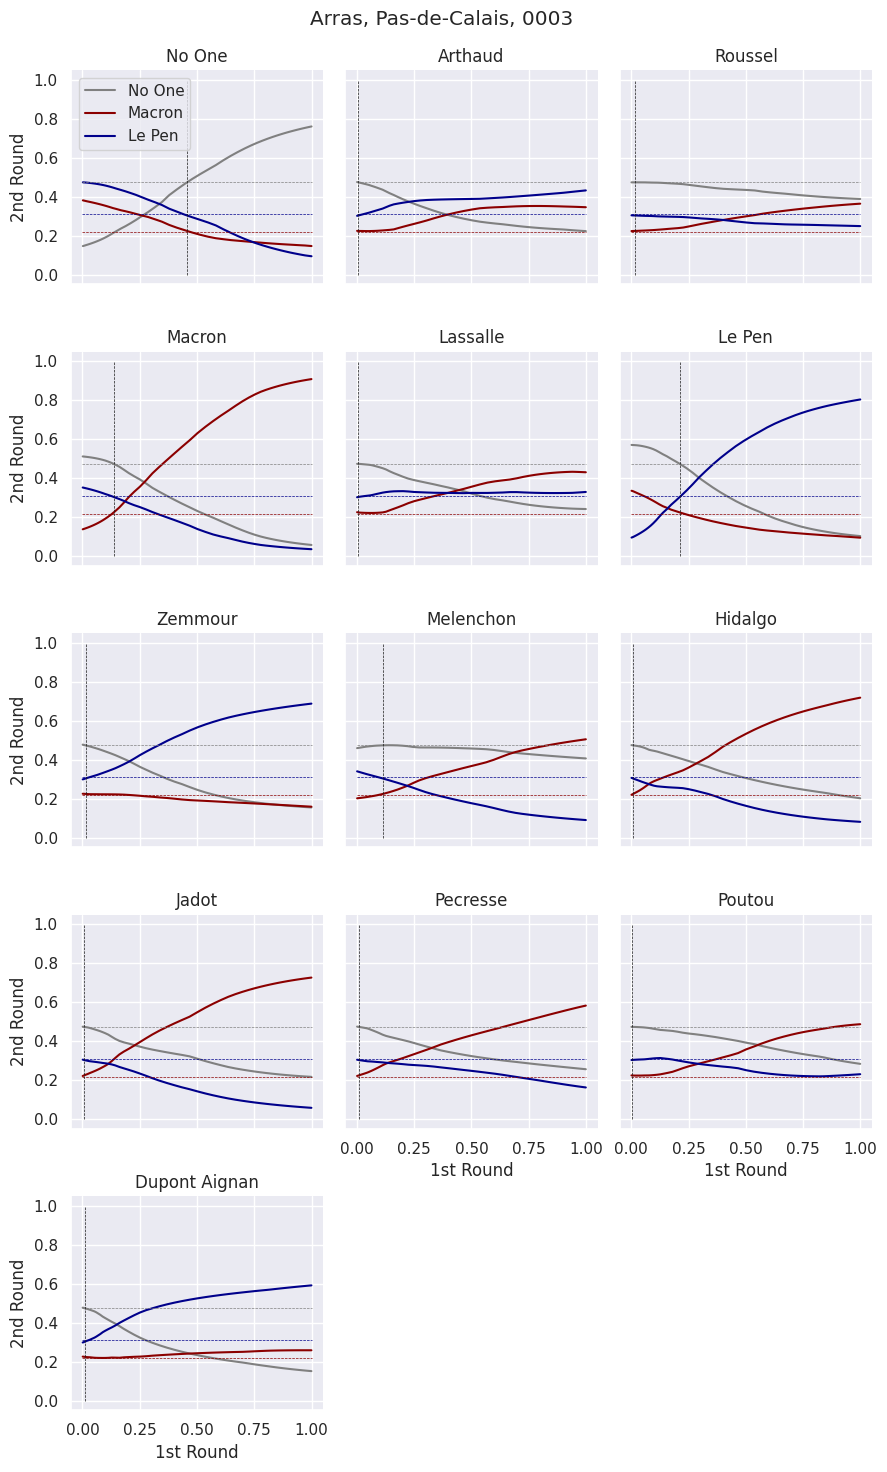

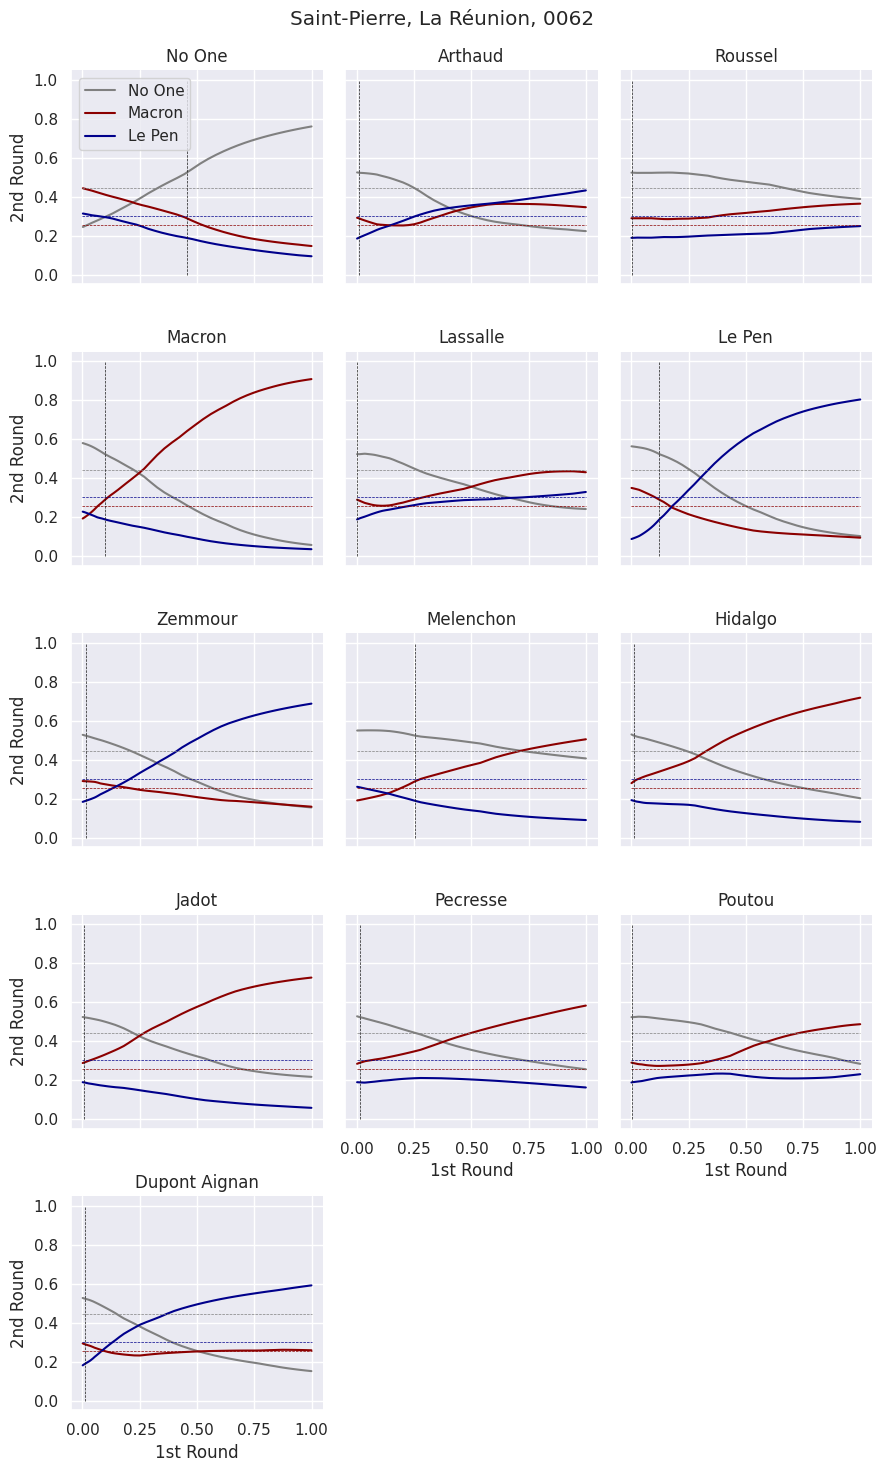

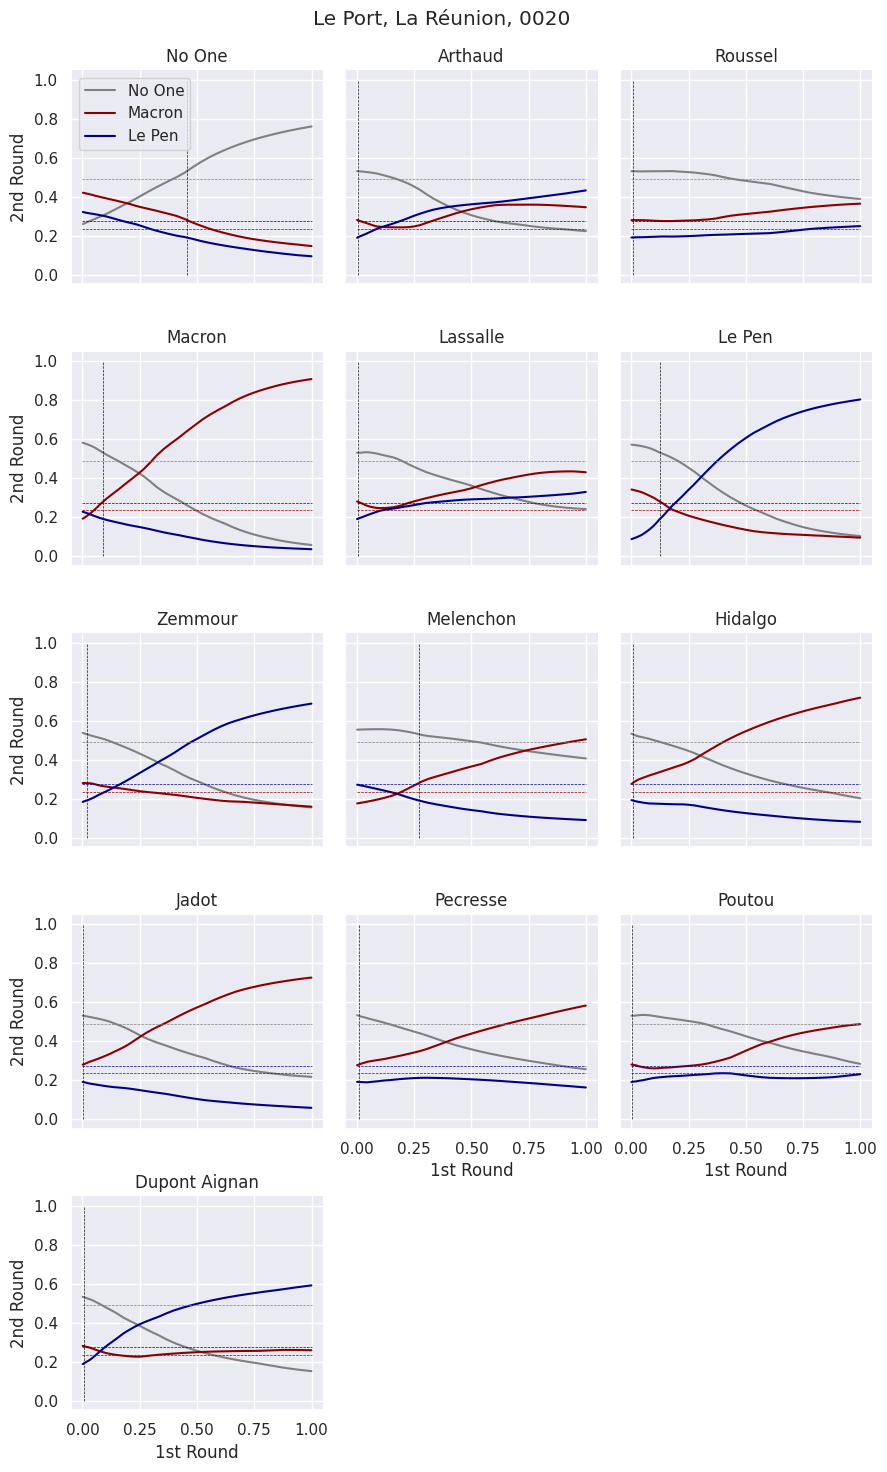

In [146]:
station_indices = prop1['No_One'].sort_values(ascending=False).index[200:205]
k = np.logspace(-3, 3, num=101)

for station_index in station_indices:
    new_prop2_hat = predict_result_multiple_choices(
        k=k,
        row_prop1=prop1.iloc[station_index],
        model=model,
        prop2_columns=prop2.columns)

    plot_results(
        new_prop2_hat=new_prop2_hat,
        station_index=station_index,
        df1=df1,
        prop1=prop1,
        prop2=prop2)


## Looking at residuals

There seems to be some structure in the error. 

The model does not predict equally well for every department. In particular, it performs  worse for departments outside of metropolitan France.

In [ ]:
prop2_all.groupby('CodeDepartement')[
    'Macron_Residual'].median().sort_values(ascending=False).head(25)

In [ ]:
prop2_all.groupby('CodeDepartement')[
    'Le_Pen_Residual'].median().sort_values(ascending=False).head(25)

In [ ]:
prop2_all.groupby('CodeDepartement')[
    'No_One_Residual'].median().sort_values(ascending=False).head(25)

We also seem to be making higher errors when there are fewer registered voters.

In [ ]:
for choice in colnames['choices2']:
    sns.lmplot(
        data=prop2_all,
        x='Inscrits',
        y=f'{choice}_Residual',
        line_kws={'color': 'red'},
        scatter_kws={'s': 1, 'color': '#ffb6c1', 'alpha': .5},
        lowess = True)
    plt.xscale("log")
    plt.ylabel("Residual")
    plt.title(choice)
    plt.show()